In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import joblib

### Exploring the dataset

In this section, I:

- Reviewed basic data types and column meanings
- Explored class imbalance in the target variable
- Looked for potential data leakage and correlated features
- Visualized the distribution of key categorical and numerical variables
- Checked for missing values, outliers, and inconsistent formatting

This step helps shape decisions around:

- Feature engineering
- Data cleaning
- Model selection (dealing with imbalanced classes)

In [2]:
df = pd.read_csv("data/bank_dataset.csv")
df.columns = [col.strip() for col in df.columns]

# Preview dataset
df.head(10)

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,...,contacts_per_campaign,N_last_days,nb_previous_contact,previous_outcome,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    41188 non-null  int64  
 1   occupation             41188 non-null  object 
 2   marital_status         41188 non-null  object 
 3   education              41188 non-null  object 
 4   has_credit             41188 non-null  object 
 5   housing_loan           41188 non-null  object 
 6   personal_loan          41188 non-null  object 
 7   contact_mode           41188 non-null  object 
 8   month                  41188 non-null  object 
 9   week_day               41188 non-null  object 
 10  last_contact_duration  41188 non-null  int64  
 11  contacts_per_campaign  41188 non-null  int64  
 12  N_last_days            41188 non-null  int64  
 13  nb_previous_contact    41188 non-null  int64  
 14  previous_outcome       4118

<Axes: title={'center': 'Target Variable Distribution'}, xlabel='target'>

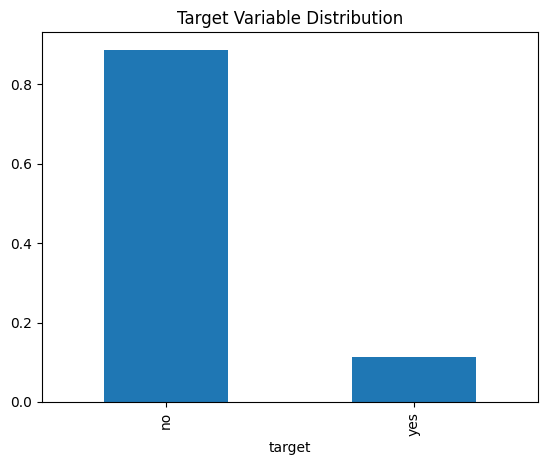

In [4]:
df['target'].value_counts(normalize=True).plot(kind='bar', title="Target Variable Distribution")

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
last_contact_duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
contacts_per_campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
N_last_days,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
nb_previous_contact,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp_var_rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons_price_index,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons_conf_index,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euri_3_month,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nb_employees,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


Text(0.5, 1.0, 'Subscription Rate by Month')

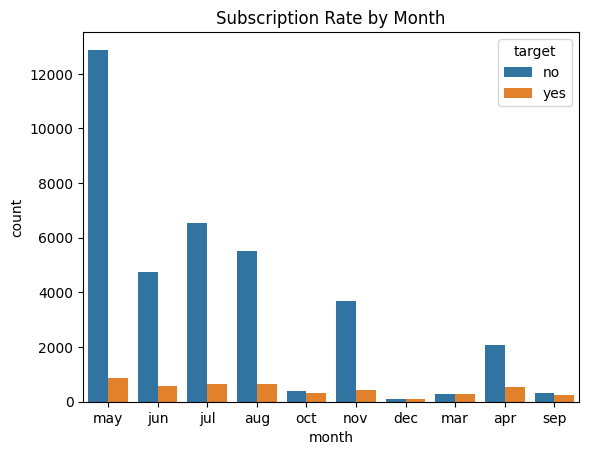

In [6]:
sns.countplot(x='month', hue='target', data=df)
plt.title("Subscription Rate by Month")

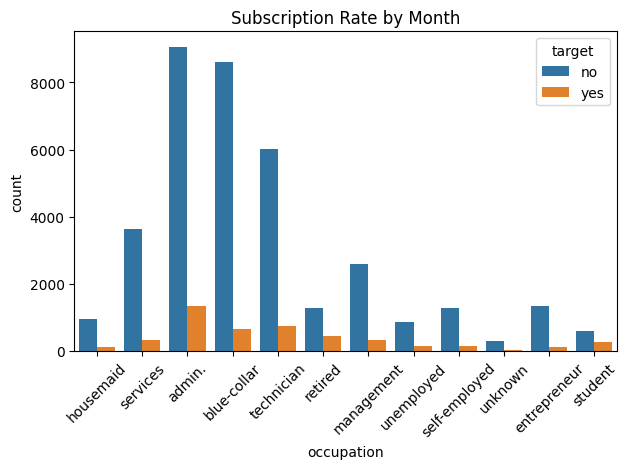

In [7]:
sns.countplot(x='occupation', hue='target', data=df)
plt.title("Subscription Rate by Month")
plt.xticks(rotation=45)  
plt.tight_layout()       

### Feature engineering: Experimenting with different features.

To ensure our models are not biased, leaky, or hindered by correlated variables, we designed a modular and versioned feature engineering pipeline. The function generate_feature_versions() outputs feature set combinations, allowing us to evaluate model robustness across different configurations.

Each feature version (v1, v2, ..., v12.1) returns:

- num_features: list of numerical columns
- cat_features: list of categorical columns

These are bundled in the feature_sets dictionary for fast experimentation.

**Nature of experiments:**

- Preventing **data leakage** (last_contact_duration)
- Avoiding **multicollinearity** by rotating correlated variables like `nb_employees`, `euri_3_month`, and `emp_var_rate`
- Testing **new engineered features** (`was_previously_contacted`, `loan_count`, `contact_gap_bucket`)
- Replace raw features with **categorical abstractions** (`age_bucket`, `contact_gap_bucket`)
- Evaluate **redundant signals** by toggling between features like `nb_previous_contact` and `contacted_multiple_times`

In [8]:
class FeatureEngineer:

    def __init__(self, df):
        self.df = df.copy()
        self.feature_set = {}
        self.target_col = 'target'  

    def add_features(self, flag=1):
        
        df = self.df.copy()

        if flag == 0:
            self.df = df
            return self.df

        #Feature indicating whether the customer was previously contacted
        df["was_previously_contacted"] = (df["N_last_days"] != 999).astype(int)

        #Bucketizing N_last_days into categorical feature
        df["contact_gap_bucket"] = pd.cut(df["N_last_days"], bins=[-1, 5, 10, 20, 40, 999], labels=["<5d", "5_10d", "10_20d", "20_40d", "never"])

        #Feature indicating whether a customer was contacted multiple times before
        df["contacted_multiple_times"] = (df["nb_previous_contact"] > 1).astype(int)

        #Feature indicating whether the contact was made on weekend
        df["is_weekend_call"] = df["week_day"].isin(["saturday", "sunday"]).astype(int)

        #Feature counting the number of loans a customer has
        df["loan_count"] = df[["has_credit", "housing_loan", "personal_loan"]].apply(lambda row: sum(val == "yes" for val in row), axis=1)

        #Bucketizing age into categorical feature
        df["age_bucket"] = pd.cut(df["age"], bins=[-1, 24, 34, 44, 54, 64, float('inf')], labels=['under_25', '25_34', '35_44', '45_54', '55_64', '65_plus'])

        self.df = df
        return self.df

    def generate_feature_sets(self):
        """
        Define multiple versions of numerical + categorical feature sets.
        """
        ### V1: Original features
        num_features_1 = ['age', 'last_contact_duration', 'contacts_per_campaign','N_last_days', 'nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees']
    
        ### V2: Removing last_contact_duration data leakage
        num_features_2 = ['age', 'contacts_per_campaign','N_last_days', 'nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees']

        ### V3: Removing contacts_per_campaign: test model against V2
        num_features_3 = ['age','N_last_days', 'nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees']

        ### V4: Adding feature was_previously_contacted
        num_features_4 = ['age', 'contacts_per_campaign','was_previously_contacted','N_last_days', 'nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees']

        ### V5: Removing N_last_days, using was_previously_contacted instead
        num_features_5 = ['age', 'contacts_per_campaign','was_previously_contacted','nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees']

        ### V6: Adding feature contacted_multiple_times
        num_features_6 = ['age', 'contacts_per_campaign','was_previously_contacted','nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees', 'contacted_multiple_times']

        ### V7: Adding feature is_weekend_call
        num_features_7 = ['age', 'contacts_per_campaign','was_previously_contacted','nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees', 'contacted_multiple_times', 'is_weekend_call']

        ### V8: Adding feature loan_count
        num_features_8 = ['age', 'contacts_per_campaign','was_previously_contacted','nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees', 'contacted_multiple_times', 'is_weekend_call', 'loan_count']

        ### V9: Replacing age with age_bucket categorical feature
        num_features_9 = ['was_previously_contacted','contacts_per_campaign','nb_previous_contact','emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees', 'contacted_multiple_times', 'is_weekend_call', 'loan_count']
    
        ### V10: nb_employees, euri_3_month and emp_var_rate are highly correlated. Rotating which one to remove.
        ### V10.1: Keeping nb_employees
        num_features_10_1 = ['contacts_per_campaign','was_previously_contacted','nb_previous_contact','cons_price_index', 'cons_conf_index', 'nb_employees', 'contacted_multiple_times', 'is_weekend_call', 'loan_count']

        ### V10.2: Keeping emp_var_rate
        num_features_10_2 = ['contacts_per_campaign','was_previously_contacted','nb_previous_contact','cons_price_index', 'cons_conf_index', 'emp_var_rate', 'contacted_multiple_times', 'is_weekend_call', 'loan_count']

        ### V10.3:  Keeping euri_3_month 
        num_features_10_3 = ['contacts_per_campaign','was_previously_contacted','nb_previous_contact','cons_price_index', 'cons_conf_index', 'euri_3_month', 'contacted_multiple_times', 'is_weekend_call', 'loan_count']

        ### V11: nb_previous_contact is correlated with contacted_multiple_times. Rotating which one to remove.
        ### V11.1: Keeping contacted_multiple_times
        num_features_11_1 = ['contacts_per_campaign','was_previously_contacted','cons_price_index', 'cons_conf_index', 'euri_3_month', 'contacted_multiple_times', 'is_weekend_call', 'loan_count']

        ### V11.2: Keeping nb_previous_contact
        num_features_11_2 = ['contacts_per_campaign','was_previously_contacted','cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_previous_contact', 'is_weekend_call', 'loan_count']

        ### V12: cons_price_index and euri_3_month are correlated. Rotating which one to remove (if at all).
        ### V12.1: Removing cons_price_index
        num_features_12_1 = ['contacts_per_campaign','was_previously_contacted', 'cons_conf_index', 'euri_3_month', 'nb_previous_contact', 'is_weekend_call', 'loan_count']

        ### V12.2: Removing euri_3_month
        num_features_12_2 = ['contacts_per_campaign','was_previously_contacted', 'cons_conf_index', 'cons_price_index', 'nb_previous_contact', 'is_weekend_call', 'loan_count']
    

        ### V1: All categorical features from the original dataset
        cat_features_1 = ['occupation', 'marital_status', 'education','has_credit', 'housing_loan', 'personal_loan','contact_mode', 'month', 'week_day', 'previous_outcome']

        ### V5: Replacing numerical N_last_days with categorical contact_gap_bucket
        cat_features_2 = ['occupation', 'marital_status', 'education','has_credit', 'housing_loan', 'personal_loan','contact_mode', 'month', 'week_day', 'previous_outcome', 'contact_gap_bucket']

        ### V8: Removing has_credit, housing_loan, personal_loan, instead using loan_count numerical feature
        cat_features_3 = ['occupation', 'marital_status', 'education','contact_mode', 'month', 'week_day', 'previous_outcome', 'contact_gap_bucket']

        ### V9: Adding age_bucket categorical feature, replacing numerical age
        cat_features_4 = ['occupation', 'marital_status', 'education','contact_mode', 'month', 'week_day', 'previous_outcome', 'contact_gap_bucket', 'age_bucket']

        self.feature_sets = {
            "v1": (num_features_1, cat_features_1),             # baseline
            "v2": (num_features_2, cat_features_1),             # no leakage: remove last_contact_duration
            "v3": (num_features_3, cat_features_1),             # explore potential leakage feature: remove contacts_per_campaign
            "v4": (num_features_4, cat_features_1),             # add new num. feature: was_previously contacted
            "v5.0": (num_features_5, cat_features_1),           # remove N_last_days, using was_previously_contacted instead
            "v5.1": (num_features_5, cat_features_2),           # replace N_last_days with categorical contact_gap_bucket
            "v6": (num_features_6, cat_features_2),             # add feature: contacted_multiple_times
            "v7": (num_features_7, cat_features_2),             # add feature: is_weekend_call
            "v8.0": (num_features_8, cat_features_2),           # add feature: loan_count
            "v8.1": (num_features_8, cat_features_3),           # replace individual loan types, keep loan_count
            "v9": (num_features_9, cat_features_4),             # replace age with age_bucket
            "10.0": (num_features_10_1, cat_features_4),        # (1/3) Rotate among correlated values. Keep nb_employees
            "10.1": (num_features_10_2, cat_features_4),        # (2/3) Rotate among correlated values. Keep emp_var_rate  
            "10.2": (num_features_10_3, cat_features_4),        # (3/3) Rotate among correlated values. Keep euri_3_month 
            "11.0": (num_features_11_1, cat_features_4),        # (1/2) Rotate among correlated values. Keep contacted_multiple_times
            "11.1": (num_features_11_2, cat_features_4),        # (2/2) Rotate among correlated values. Keep nb_previous_contact
            "12.0": (num_features_12_1, cat_features_4),        # (1/2) Rotate among correlated values. Keep euri_3_month
            "12.1": (num_features_12_2, cat_features_4),        # (2/2) Rotate among correlated values. Keep cons_price_index
        }

        return self.feature_sets

    def correlation_matrix(self):
        df = self.df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        corr = df[numeric_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
        plt.title("Correlation Matrix of Numerical Features")
        plt.tight_layout()
        plt.show()

### Correlation Matrix

Visualizing correlations between numerical features to identify potential multicollinearity issues and guide informed feature selection.

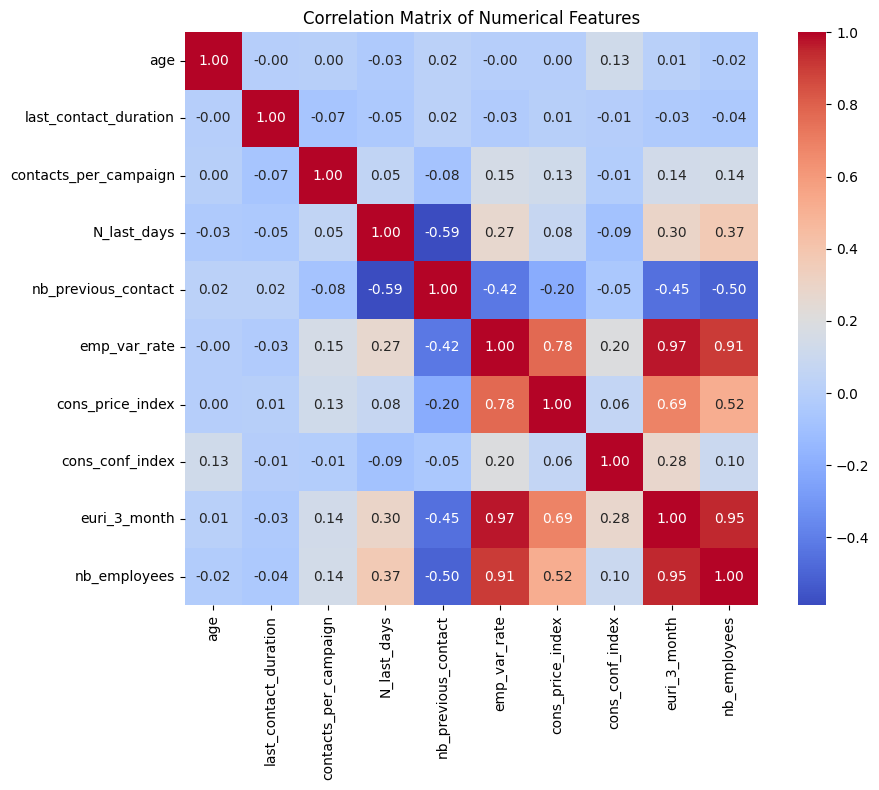

In [9]:
df = pd.read_csv('data\\bank_dataset.csv')
fe = FeatureEngineer(df)
fe.correlation_matrix()
df = fe.add_features(flag=1)
feature_sets = fe.generate_feature_sets()
num_features, cat_features = feature_sets["v9"]

### Model 1: Logistic Regression

Model trained and saved as 'model_logreg.pkl'

--- Evaluation Report ---
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      7310
           1       0.37      0.65      0.47       928

    accuracy                           0.84      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.84      0.85      8238

ROC AUC: 0.8022130318647106
Precision: 0.3678724708767627
Recall: 0.646551724137931
F1: 0.46893317702227433
PR AUC: 0.4593262190291433
Log Loss: 0.5150593880185067
Brier Score: 0.16169767029904905

--- Cross-Validation ---
Fold 1: AUC=0.7869, Precision=0.3479, Recall=0.6088, F1=0.4428
Fold 2: AUC=0.7862, Precision=0.3438, Recall=0.6110, F1=0.4400
Fold 3: AUC=0.8030, Precision=0.3627, Recall=0.6487, F1=0.4652
Fold 4: AUC=0.7894, Precision=0.3471, Recall=0.6336, F1=0.4485
Fold 5: AUC=0.7930, Precision=0.3626, Recall=0.6325, F1=0.4609

--- Final Cross-Validation Results ---
Mean AUC: 0.7917
Mean 

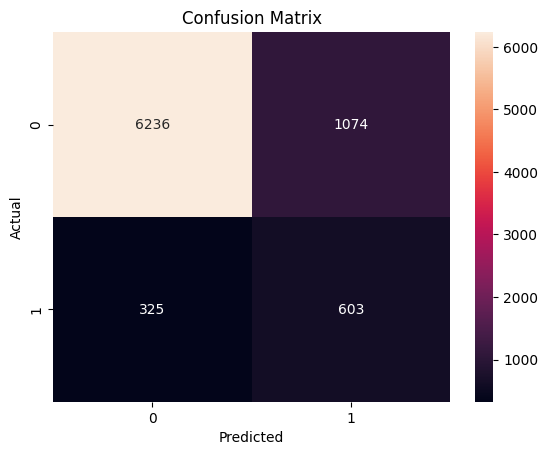

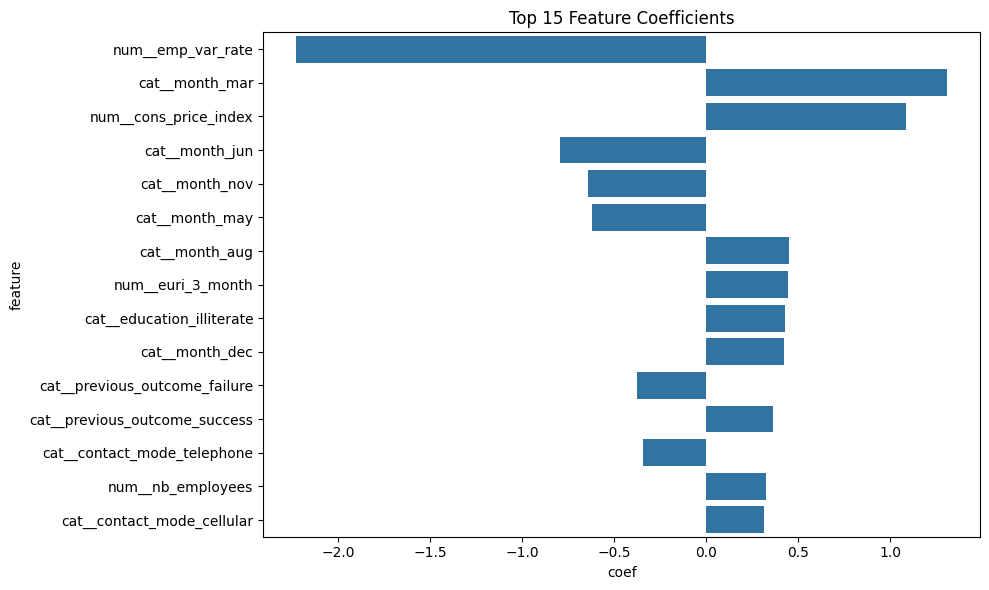


Threshold: 0.1
Precision: 0.113
Recall:    1.000
F1 Score:  0.202

Threshold: 0.2
Precision: 0.122
Recall:    0.974
F1 Score:  0.217

Threshold: 0.3
Precision: 0.169
Recall:    0.872
F1 Score:  0.283

Threshold: 0.4
Precision: 0.276
Recall:    0.734
F1 Score:  0.401

Threshold: 0.5
Precision: 0.360
Recall:    0.650
F1 Score:  0.463

Threshold: 0.6
Precision: 0.414
Recall:    0.620
F1 Score:  0.496

Threshold: 0.7
Precision: 0.473
Recall:    0.528
F1 Score:  0.499

Threshold: 0.8
Precision: 0.527
Recall:    0.412
F1 Score:  0.462


In [10]:
class LogisticRegressionModel:

    def __init__(self, df, num_features, cat_features, target_col):
        self.num_features = num_features
        self.cat_features = cat_features
        self.target_col = target_col
        self.model = None
        self.preprocessor = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.df = df
        

    def build_pipeline(self):
        numeric_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ])

        self.preprocessor = ColumnTransformer([
            ("num", numeric_transformer, self.num_features),
            ("cat", categorical_transformer, self.cat_features)
        ])

        self.model = Pipeline([
            ("preprocessor", self.preprocessor),
            ("classifier", LogisticRegression(
                max_iter=1000,
                random_state=42,
                class_weight="balanced"
            ))
        ])

        return self.model

    def train(self):
        self.X = self.df[self.num_features + self.cat_features]
        self.y = self.df[self.target_col].apply(lambda val: 1 if val == "yes" else 0)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42, stratify=self.y)

        if self.model is None:
            self.build_pipeline()

        self.model.fit(self.X_train, self.y_train)
        joblib.dump(self.model, "trained_models\\model_logreg.pkl")
        print("Model trained and saved as 'model_logreg.pkl'")

    def evaluate(self):
        y_prob = self.model.predict_proba(self.X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        print("\n--- Evaluation Report ---")
        print(classification_report(self.y_test, y_pred))
        print("ROC AUC:", roc_auc_score(self.y_test, y_prob))
        print("Precision:", precision_score(self.y_test, y_pred))
        print("Recall:", recall_score(self.y_test, y_pred))
        print("F1:", f1_score(self.y_test, y_pred))
        print("PR AUC:", average_precision_score(self.y_test, y_prob))
        print("Log Loss:", log_loss(self.y_test, y_prob))
        print("Brier Score:", brier_score_loss(self.y_test, y_prob))

    def cross_validate(self, k=5):
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        metrics = {"auc": [], "precision": [], "recall": [], "f1": []}

        print("\n--- Cross-Validation ---")
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X, self.y)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]

            model_fold = self.build_pipeline()
            model_fold.fit(X_train, y_train)
            y_prob = model_fold.predict_proba(X_val)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            metrics["auc"].append(roc_auc_score(y_val, y_prob))
            metrics["precision"].append(precision_score(y_val, y_pred))
            metrics["recall"].append(recall_score(y_val, y_pred))
            metrics["f1"].append(f1_score(y_val, y_pred))

            print(f"Fold {fold+1}: AUC={metrics['auc'][-1]:.4f}, "
                  f"Precision={metrics['precision'][-1]:.4f}, "
                  f"Recall={metrics['recall'][-1]:.4f}, "
                  f"F1={metrics['f1'][-1]:.4f}")

        print("\n--- Final Cross-Validation Results ---")
        for key, values in metrics.items():
            print(f"Mean {key.upper()}: {np.mean(values):.4f}")

    def plot_confusion_matrix(self):

        y_prob = self.model.predict_proba(self.X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
        plt.show()

    def plot_important_features(self):

        importance = self.model.named_steps["classifier"].coef_[0]
        feature_names = self.preprocessor.get_feature_names_out()
        imp_df = pd.DataFrame({"feature": feature_names, "coef": importance})
        imp_df = imp_df.sort_values("coef", key=abs, ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x="coef", y="feature", data=imp_df.head(15))
        plt.title("Top 15 Feature Coefficients")
        plt.tight_layout()
        plt.show()

    def test_thresholds(self):

        y_prob = self.model.predict_proba(self.X_test)[:, 1]

        for t in np.arange(0.1, 0.9, 0.1):
            y_pred = (y_prob >= t).astype(int)
            print(f"\nThreshold: {t:.1f}")
            print(f"Precision: {precision_score(self.y_test, y_pred):.3f}")
            print(f"Recall:    {recall_score(self.y_test, y_pred):.3f}")
            print(f"F1 Score:  {f1_score(self.y_test, y_pred):.3f}")
        
num_features, cat_features = feature_sets["v3"]
logreg_model = LogisticRegressionModel(df, num_features, cat_features, target_col='target')
logreg_model.train()
logreg_model.evaluate()
logreg_model.cross_validate(k=5)
logreg_model.plot_confusion_matrix()
logreg_model.plot_important_features()
logreg_model.test_thresholds()

### Model 2: LightGBM

Model trained and saved as 'mmodel_lgbm.pkl'

--- Evaluation Report ---
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      7310
           1       0.40      0.65      0.50       928

    accuracy                           0.85      8238
   macro avg       0.68      0.76      0.70      8238
weighted avg       0.89      0.85      0.87      8238

ROC AUC: 0.8096322350110854
Precision: 0.3990795529257068
Recall: 0.6540948275862069
F1: 0.4957125357288689
PR AUC: 0.4868717631362889
Log Loss: 0.46864471617616354
Brier Score: 0.14455035872273872

--- Cross-Validation ---


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1: AUC=0.7928, Precision=0.3776, Recall=0.6218, F1=0.4699


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2: AUC=0.7978, Precision=0.3622, Recall=0.6228, F1=0.4580


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3: AUC=0.8084, Precision=0.3864, Recall=0.6379, F1=0.4813


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4: AUC=0.8002, Precision=0.3574, Recall=0.6519, F1=0.4617


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5: AUC=0.8051, Precision=0.3977, Recall=0.6304, F1=0.4877

--- Final Cross-Validation Results ---
Mean AUC: 0.8009
Mean PRECISION: 0.3762
Mean RECALL: 0.6330
Mean F1: 0.4717

Threshold: 0.1
Precision: 0.118
Recall:    0.995
F1 Score:  0.211

Threshold: 0.2
Precision: 0.147
Recall:    0.960
F1 Score:  0.255

Threshold: 0.3
Precision: 0.210
Recall:    0.907
F1 Score:  0.341

Threshold: 0.4
Precision: 0.323
Recall:    0.798
F1 Score:  0.460

Threshold: 0.5
Precision: 0.420
Recall:    0.696
F1 Score:  0.524

Threshold: 0.6
Precision: 0.488
Recall:    0.643
F1 Score:  0.555

Threshold: 0.7
Precision: 0.545
Recall:    0.599
F1 Score:  0.571

Threshold: 0.8
Precision: 0.619
Recall:    0.496
F1 Score:  0.551


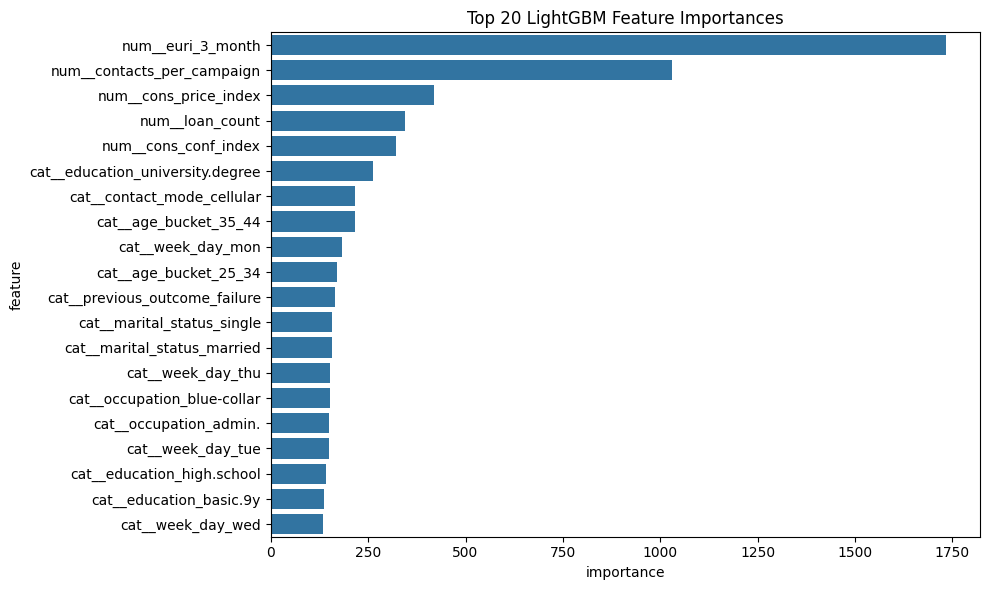

In [11]:
class LightGBMModel:

    def __init__(self, df, num_features, cat_features, target_col):
        self.num_features = num_features
        self.cat_features = cat_features
        self.target_col = target_col
        self.model = None
        self.preprocessor = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.df = df.copy()

    def build_pipeline(self):

        numeric_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        self.preprocessor = ColumnTransformer([
            ("num", numeric_transformer, self.num_features),
            ("cat", categorical_transformer, self.cat_features)
        ])

        self.model = Pipeline(steps=[
            ("preprocessor", self.preprocessor),
            ("classifier", LGBMClassifier(random_state=42,class_weight='balanced',n_estimators=300,learning_rate=0.05,max_depth=6, verbose=-1))
        ])

        return self.model

    def train(self):

        features = self.num_features + self.cat_features
        self.df[self.cat_features] = self.df[self.cat_features].astype("category")
        self.X = self.df[features]
        self.y = self.df[self.target_col].apply(lambda x: 1 if x == 'yes' else 0)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42, stratify=self.y)

        if self.model is None:
            self.build_pipeline()

        self.model.fit(self.X_train, self.y_train)
        joblib.dump(self.model, "trained_models\\model_lgbm.pkl") ### needed for the API application
        print("Model trained and saved as 'mmodel_lgbm.pkl'")

    def evaluate(self):
        y_prob = self.model.predict_proba(self.X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        print("\n--- Evaluation Report ---")
        print(classification_report(self.y_test, y_pred))
        print("ROC AUC:", roc_auc_score(self.y_test, y_prob))
        print("Precision:", precision_score(self.y_test, y_pred))
        print("Recall:", recall_score(self.y_test, y_pred))
        print("F1:", f1_score(self.y_test, y_pred))
        print("PR AUC:", average_precision_score(self.y_test, y_prob))
        print("Log Loss:", log_loss(self.y_test, y_prob))
        print("Brier Score:", brier_score_loss(self.y_test, y_prob))

    def cross_validate(self, k=5):
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        metrics = {"auc": [], "precision": [], "recall": [], "f1": []}

        print("\n--- Cross-Validation ---")
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X, self.y)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]

            model_fold = self.build_pipeline()
            model_fold.fit(X_train, y_train)
            y_prob = model_fold.predict_proba(X_val)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            metrics["auc"].append(roc_auc_score(y_val, y_prob))
            metrics["precision"].append(precision_score(y_val, y_pred))
            metrics["recall"].append(recall_score(y_val, y_pred))
            metrics["f1"].append(f1_score(y_val, y_pred))

            print(f"Fold {fold+1}: AUC={metrics['auc'][-1]:.4f}, "
                  f"Precision={metrics['precision'][-1]:.4f}, "
                  f"Recall={metrics['recall'][-1]:.4f}, "
                  f"F1={metrics['f1'][-1]:.4f}")

        print("\n--- Final Cross-Validation Results ---")
        for key, values in metrics.items():
            print(f"Mean {key.upper()}: {np.mean(values):.4f}")

    def test_thresholds(self):

        y_prob = self.model.predict_proba(self.X_test)[:, 1]

        for t in np.arange(0.1, 0.9, 0.1):
            y_pred = (y_prob >= t).astype(int)
            print(f"\nThreshold: {t:.1f}")
            print(f"Precision: {precision_score(self.y_test, y_pred):.3f}")
            print(f"Recall:    {recall_score(self.y_test, y_pred):.3f}")
            print(f"F1 Score:  {f1_score(self.y_test, y_pred):.3f}")

    def plot_feature_importance(self):
        fitted_model = self.model.named_steps["classifier"]
        feature_names = self.model.named_steps["preprocessor"].get_feature_names_out()
        importances = fitted_model.feature_importances_

        imp_df = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).sort_values("importance", ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=imp_df.head(20), x="importance", y="feature")
        plt.title("Top 20 LightGBM Feature Importances")
        plt.tight_layout()
        plt.show()

num_features, cat_features = feature_sets["11.0"]        
lgbm_model = LightGBMModel(df, num_features, cat_features, target_col='target')
lgbm_model.train()
lgbm_model.evaluate()
lgbm_model.cross_validate(k=5)
lgbm_model.test_thresholds()
lgbm_model.plot_feature_importance()

### Model 3: Random Forest

Model trained and saved as 'model_rand_forest.pkl'

--- Evaluation Report ---
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      7310
           1       0.38      0.64      0.47       928

    accuracy                           0.84      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.89      0.84      0.86      8238

ROC AUC: 0.8070500819614133
Precision: 0.377466581795035
Recall: 0.6390086206896551
F1: 0.47458983593437376
PR AUC: 0.4743019872116782
Log Loss: 0.5077341880784394
Brier Score: 0.16052766931666218

--- Cross-Validation ---
Fold 1: AUC=0.7901, Precision=0.3572, Recall=0.6078, F1=0.4499
Fold 2: AUC=0.7939, Precision=0.3483, Recall=0.6034, F1=0.4416
Fold 3: AUC=0.8084, Precision=0.3775, Recall=0.6412, F1=0.4752
Fold 4: AUC=0.7936, Precision=0.3601, Recall=0.6325, F1=0.4590
Fold 5: AUC=0.7929, Precision=0.3768, Recall=0.6325, F1=0.4722

--- Final Cross-Validation Results ---
Mean AUC: 0.7958


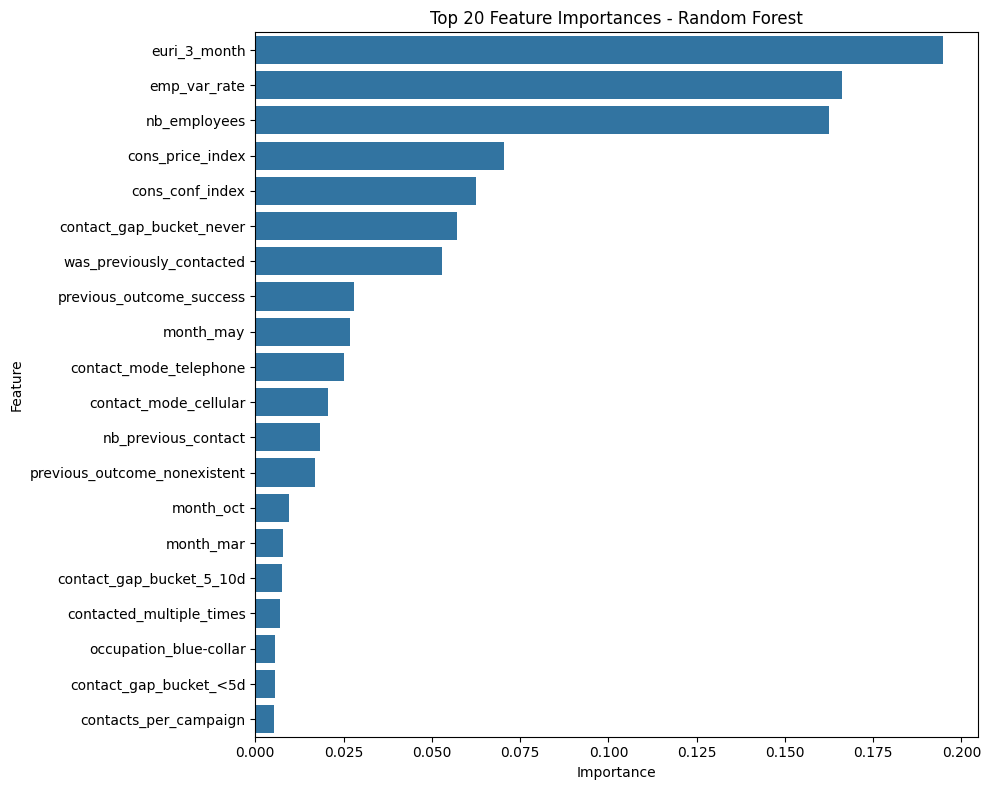

In [12]:
class RandomForestModel:

    def __init__(self, df, num_features, cat_features, target_col):
        self.num_features = num_features
        self.cat_features = cat_features
        self.target_col = target_col
        self.model = None
        self.preprocessor = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.df = df

    def build_pipeline(self):
        numeric_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])

        categorical_transformer = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ])

        self.preprocessor = ColumnTransformer([
            ("num", numeric_transformer, self.num_features),
            ("cat", categorical_transformer, self.cat_features)
        ])

        self.model = Pipeline([
            ("preprocessor", self.preprocessor),
            ("classifier", RandomForestClassifier(
                n_estimators=200,
                max_depth=6,
                class_weight="balanced",
                random_state=42
            ))
        ])

        return self.model

    def train(self):
        self.X = self.df[self.num_features + self.cat_features]
        self.y = self.df[self.target_col].apply(lambda val: 1 if val == "yes" else 0)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42, stratify=self.y)

        if self.model is None:
            self.build_pipeline()

        self.model.fit(self.X_train, self.y_train)
        joblib.dump(self.model, "trained_models\\model_rand_forest.pkl")
        print("Model trained and saved as 'model_rand_forest.pkl'")

    def evaluate(self):
        y_prob = self.model.predict_proba(self.X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        print("\n--- Evaluation Report ---")
        print(classification_report(self.y_test, y_pred))
        print("ROC AUC:", roc_auc_score(self.y_test, y_prob))
        print("Precision:", precision_score(self.y_test, y_pred))
        print("Recall:", recall_score(self.y_test, y_pred))
        print("F1:", f1_score(self.y_test, y_pred))
        print("PR AUC:", average_precision_score(self.y_test, y_prob))
        print("Log Loss:", log_loss(self.y_test, y_prob))
        print("Brier Score:", brier_score_loss(self.y_test, y_prob))

    def cross_validate(self, k=5):
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        metrics = {"auc": [], "precision": [], "recall": [], "f1": []}

        print("\n--- Cross-Validation ---")
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X, self.y)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]

            model_fold = self.build_pipeline()
            model_fold.fit(X_train, y_train)
            y_prob = model_fold.predict_proba(X_val)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            metrics["auc"].append(roc_auc_score(y_val, y_prob))
            metrics["precision"].append(precision_score(y_val, y_pred))
            metrics["recall"].append(recall_score(y_val, y_pred))
            metrics["f1"].append(f1_score(y_val, y_pred))

            print(f"Fold {fold+1}: AUC={metrics['auc'][-1]:.4f}, "
                  f"Precision={metrics['precision'][-1]:.4f}, "
                  f"Recall={metrics['recall'][-1]:.4f}, "
                  f"F1={metrics['f1'][-1]:.4f}")

        print("\n--- Final Cross-Validation Results ---")
        for key, values in metrics.items():
            print(f"Mean {key.upper()}: {np.mean(values):.4f}")

    def test_thresholds(self):

        y_prob = self.model.predict_proba(self.X_test)[:, 1]

        for t in np.arange(0.1, 0.9, 0.1):
            y_pred = (y_prob >= t).astype(int)
            print(f"\nThreshold: {t:.1f}")
            print(f"Precision: {precision_score(self.y_test, y_pred):.3f}")
            print(f"Recall:    {recall_score(self.y_test, y_pred):.3f}")
            print(f"F1 Score:  {f1_score(self.y_test, y_pred):.3f}")

    def plot_feature_importance(self):
        rf_model = self.model.named_steps['classifier']

        ohe = self.model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
        cat_feature_names = ohe.get_feature_names_out(self.cat_features)
        all_feature_names = np.concatenate([self.num_features, cat_feature_names])

        feature_importances = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_importances.head(20), x='Importance', y='Feature')
        plt.title('Top 20 Feature Importances - Random Forest')
        plt.tight_layout()
        plt.show()

num_features, cat_features = feature_sets["v9"]  
rf_model = RandomForestModel(df, num_features, cat_features, target_col='target')
rf_model.train()
rf_model.evaluate()
rf_model.cross_validate(k=5)
rf_model.test_thresholds()
rf_model.plot_feature_importance()

### Model 4: Voting Classifier Model

In [32]:
class VotingClassifierModel:

    def __init__(self, df, num_features, cat_features, target_col):
        self.num_features = num_features
        self.cat_features = cat_features
        self.target_col = target_col
        self.model = None
        self.preprocessor = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.df = df

    def build_pipeline(self):

        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine them
        self.preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.num_features),
            ('cat', categorical_transformer, self.cat_features)
        ])

        logreg = LogisticRegression(max_iter=1000, class_weight='balanced',random_state=42)
        rf = RandomForestClassifier(n_estimators=200, max_depth=6, class_weight='balanced', random_state=42)
        lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, class_weight='balanced', random_state=42, verbose=-1)

        self.model = Pipeline(steps=[
            ('preprocessor', self.preprocessor),
            ('classifier', VotingClassifier(
                estimators=[
                    ('lr', logreg),
                    ('rf', rf),
                    ('lgbm', lgbm)
                ],
                voting='soft'  # Use predicted probabilities (better for imbalance)
            ))
        ])

        return self.model

    def train(self):
        self.X = self.df[self.num_features + self.cat_features]
        self.y = self.df[self.target_col].apply(lambda val: 1 if val == "yes" else 0)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42, stratify=self.y)

        if self.model is None:
            self.build_pipeline()

        self.model.fit(self.X_train, self.y_train)
        joblib.dump(self.model, "trained_models\\model_voting_classifier.pkl")
        print("Model trained and saved as 'model_voting_classifier.pkl'")

    def evaluate(self):
        y_prob = self.model.predict_proba(self.X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        print("\n--- Evaluation Report ---")
        print(classification_report(self.y_test, y_pred))
        print("ROC AUC:", roc_auc_score(self.y_test, y_prob))
        print("Precision:", precision_score(self.y_test, y_pred))
        print("Recall:", recall_score(self.y_test, y_pred))
        print("F1:", f1_score(self.y_test, y_pred))
        print("PR AUC:", average_precision_score(self.y_test, y_prob))
        print("Log Loss:", log_loss(self.y_test, y_prob))
        print("Brier Score:", brier_score_loss(self.y_test, y_prob))

    def cross_validate(self, k=5):
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        metrics = {"auc": [], "precision": [], "recall": [], "f1": []}

        print("\n--- Cross-Validation ---")
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X, self.y)):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]

            model_fold = self.build_pipeline()
            model_fold.fit(X_train, y_train)
            y_prob = model_fold.predict_proba(X_val)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            metrics["auc"].append(roc_auc_score(y_val, y_prob))
            metrics["precision"].append(precision_score(y_val, y_pred))
            metrics["recall"].append(recall_score(y_val, y_pred))
            metrics["f1"].append(f1_score(y_val, y_pred))

            print(f"Fold {fold+1}: AUC={metrics['auc'][-1]:.4f}, "
                  f"Precision={metrics['precision'][-1]:.4f}, "
                  f"Recall={metrics['recall'][-1]:.4f}, "
                  f"F1={metrics['f1'][-1]:.4f}")

        print("\n--- Final Cross-Validation Results ---")
        for key, values in metrics.items():
            print(f"Mean {key.upper()}: {np.mean(values):.4f}")

    def test_thresholds(self):

        y_prob = self.model.predict_proba(self.X_test)[:, 1]

        for t in np.arange(0.1, 0.9, 0.1):
            y_pred = (y_prob >= t).astype(int)
            print(f"\nThreshold: {t:.1f}")
            print(f"Precision: {precision_score(self.y_test, y_pred):.3f}")
            print(f"Recall:    {recall_score(self.y_test, y_pred):.3f}")
            print(f"F1 Score:  {f1_score(self.y_test, y_pred):.3f}")

    def individual_model_performance(self):
        voting_clf = self.model.named_steps['classifier']

        model_names = voting_clf.named_estimators_.keys()
        model_list = voting_clf.named_estimators_.values()

        X_test_transformed = self.model.named_steps['preprocessor'].transform(self.X_test)

        for name, model in zip(model_names, model_list):
            y_pred_individual = model.predict(X_test_transformed)
            acc = roc_auc_score(self.y_test, y_pred_individual)
            print(f"{name} roc auc: {acc:.4f}")

num_features, cat_features = feature_sets["v9"] 
voting_model = VotingClassifierModel(df, num_features, cat_features, target_col='target')
voting_model.train()
voting_model.evaluate()
voting_model.cross_validate(k=5)
voting_model.test_thresholds()
voting_model.individual_model_performance()

Model trained and saved as 'model_voting_classifier.pkl'


### Feature evaluator

In [16]:
class FeatureEvaluator:

    def __init__(self, df, fe, model_class, target_metric='roc_auc'): 
        """
        df: pandas DataFrame
        feature_engineer: instance of FeatureEngineer
        model_class: model class to instantiate (e.g., LogisticRegressionModel)
        target_metric: which metric to optimize ("roc_auc", "precision", "recall", "f1", "pr_auc")
        """
        self.df = df.copy()
        self.fe = fe
        self.model_class = model_class
        self.target_metric = target_metric
        self.results = []

    def evaluate_all(self):
        feature_sets = self.fe.generate_feature_sets()

        for version, (num_features, cat_features) in feature_sets.items():
            print(f"\nEvaluating Feature Set Version: {version}")
            if version == "v1":
                print("\n Skipping baseline version v1.")
                continue

            model = self.model_class(self.df, num_features, cat_features, target_col='target')
            model.train()

            y_prob = model.model.predict_proba(model.X_test)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            roc_auc = roc_auc_score(model.y_test, y_prob)
            precision = precision_score(model.y_test, y_pred)
            recall = recall_score(model.y_test, y_pred)
            f1 = f1_score(model.y_test, y_pred)
            pr_auc = average_precision_score(model.y_test, y_prob)

            self.results.append({
                "version": version,
                "roc_auc": roc_auc,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "pr_auc": pr_auc
            })

        results_df = pd.DataFrame(self.results)
        print("\n--- Feature Set Evaluation Results ---")
        print(results_df.sort_values(by=self.target_metric, ascending=False))

Evaluating all feature sets for the **Logistic Regression** model to identify the best version

Results:

- **v3** maximizes roc_auc
- **v2** maximizes precision
- **v12.0** maximizes recall

In [20]:
feature_evaluator = FeatureEvaluator(df, fe, model_class=LogisticRegressionModel, target_metric='recall')
feature_evaluator.evaluate_all()


Evaluating Feature Set Version: v1

 Skipping baseline version v1.

Evaluating Feature Set Version: v2
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v3
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v4
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v5.0
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v5.1
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v6
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v7
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v8.0
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v8.1
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: v9
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature Set Version: 10.0
Model trained and saved as 'model_logreg.pkl'

Evaluating Feature 

Evaluating the feature sets for the **Light GBM** model to identify the best version

Results:

- **v11.0** maximizes roc_auc
- **v3** maximizes precision
- **v11.1** maximizes recall


In [22]:
feature_evaluator = FeatureEvaluator(df, fe, model_class=LightGBMModel, target_metric='recall')
feature_evaluator.evaluate_all()


Evaluating Feature Set Version: v1

 Skipping baseline version v1.

Evaluating Feature Set Version: v2
Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v3


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v4


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v5.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v5.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v6


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v7


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v8.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v8.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: v9


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: 10.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: 10.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: 10.2


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: 11.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: 11.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: 12.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

Evaluating Feature Set Version: 12.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'mmodel_lgbm.pkl'

--- Feature Set Evaluation Results ---
   version   roc_auc  precision    recall        f1    pr_auc
14    11.1  0.808368   0.396484  0.656250  0.494318  0.487604
12    10.2  0.807772   0.395969  0.656250  0.493917  0.487538
9       v9  0.808742   0.391360  0.654095  0.489714  0.488628
13    11.0  0.809632   0.399080  0.654095  0.495713  0.486872
15    12.0  0.809541   0.395820  0.653017  0.492883  0.488983
8     v8.1  0.809546   0.394256  0.650862  0.491057  0.487461
7     v8.0  0.808225   0.399867  0.649784  0.495074  0.486345
3     v5.0  0.808409   0.396189  0.649784  0.492245  0.485686
0       v2  0.809205   0.395655  0.647629  0.491214  0.486647
2       v4  0.809205   0.395655  0.647629  0.491214  0.486647
6       v7  0.809066   0.397750  0.647629  0.492825  0.488878
5       v6  0.809066   0.397750  0.647629  0.492825  0.488878
4     v5.1  0.809103   0.396689  0.645474  0.491386  0.485879
1       v3  0.807723   0.403378  0.643319  0.49

C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluating the feature sets for the **Random Forest** model to identify the best version

Results:

- **v9** maximizes roc_auc


In [26]:
feature_evaluator = FeatureEvaluator(df, fe, model_class=RandomForestModel, target_metric='roc_auc')
feature_evaluator.evaluate_all()


Evaluating Feature Set Version: v1

 Skipping baseline version v1.

Evaluating Feature Set Version: v2
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v3
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v4
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v5.0
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v5.1
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v6
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v7
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v8.0
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v8.1
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: v9
Model trained and saved as 'model_rand_forest.pkl'

Evaluating Feature Set Version: 10.0
Model trained an

Evaluating the feature sets for the **Voting Classifier** model to identify the best version

Results:

- **v9** maximizes roc_auc

In [27]:
feature_evaluator = FeatureEvaluator(df, fe, model_class=VotingClassifierModel, target_metric='roc_auc')
feature_evaluator.evaluate_all()


Evaluating Feature Set Version: v1

 Skipping baseline version v1.

Evaluating Feature Set Version: v2
Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v3


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v4


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v5.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v5.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v6


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v7


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v8.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v8.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: v9


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: 10.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: 10.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: 10.2


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: 11.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: 11.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: 12.0


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

Evaluating Feature Set Version: 12.1


C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model trained and saved as 'model_voting_classifier.pkl'

--- Feature Set Evaluation Results ---
   version   roc_auc  precision    recall        f1    pr_auc
9       v9  0.810304   0.392996  0.653017  0.490688  0.484542
13    11.0  0.810284   0.387179  0.650862  0.485531  0.482918
8     v8.1  0.810269   0.385304  0.649784  0.483755  0.481400
4     v5.1  0.810102   0.388205  0.645474  0.484824  0.480898
2       v4  0.810040   0.385842  0.651940  0.484776  0.482794
5       v6  0.809936   0.390433  0.650862  0.488081  0.483147
0       v2  0.809872   0.384860  0.651940  0.484000  0.483373
1       v3  0.809767   0.392016  0.645474  0.487785  0.475464
6       v7  0.809758   0.389175  0.650862  0.487097  0.481670
3     v5.0  0.809688   0.386335  0.651940  0.485164  0.481079
7     v8.0  0.809598   0.392068  0.649784  0.489051  0.481603
14    11.1  0.809579   0.385246  0.658405  0.486078  0.480545
12    10.2  0.809482   0.386120  0.659483  0.487067  0.482061
15    12.0  0.809430   0.384471  0.

C:\Users\iulia\code_projects\2021ai_assignment\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
